In [1]:
using TSML
using TSML.Utils
using TSML.TSMLTypes
using TSML.TSMLTransformers
using TSML.Statifiers
using TSML.DataReaders
using TSML.Monotonicers
using TSML.Monotonicers: ismonotonic

using DataFrames
using Dates
using Random

┌ Info: Precompiling TSML [198dc43e-9e51-5cd7-9d40-d9794d335912]
└ @ Base loading.jl:1192


## Introduce some missing data

In [4]:
Random.seed!(144)
dt=[missing;rand(1:10,3);missing;missing;missing;rand(1:5,3)]
dat = DataFrame(Date= DateTime(2017,12,31,1):Dates.Hour(1):DateTime(2017,12,31,10) |> collect,Value = dt)

,Date,Value
,DateTime,Int64⍰
1,2017-12-31T01:00:00,missing
2,2017-12-31T02:00:00,9
3,2017-12-31T03:00:00,7
4,2017-12-31T04:00:00,9
5,2017-12-31T05:00:00,missing
6,2017-12-31T06:00:00,missing
7,2017-12-31T07:00:00,missing
8,2017-12-31T08:00:00,3
9,2017-12-31T09:00:00,5


## Get statistics including blocks of missing data

In [6]:
statfier = Statifier(Dict(:processmissing=>true))
fit!(statfier,dat)
res=transform!(statfier,dat)
show(res,allcols=true)

1×26 DataFrame
│ Row │ TStart              │ TEnd                │ SFreq   │ count │ max   │
│     │ DateTime            │ DateTime            │ Float64 │ Int64 │ Int64 │
├─────┼─────────────────────┼─────────────────────┼─────────┼───────┼───────┤
│ 1   │ 2017-12-31T01:00:00 │ 2017-12-31T10:00:00 │ 0.9     │ 6     │ 9     │

│ Row │ min   │ median  │ mean    │ q1      │ q2      │ q25     │ q75     │
│     │ Int64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼───────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ 2     │ 6.0     │ 5.83333 │ 2.5     │ 3.0     │ 3.5     │ 8.5     │

│ Row │ q8      │ q9      │ kurtosis │ skewness  │ variation │ entropy  │
│     │ Float64 │ Float64 │ Float64  │ Float64   │ Float64   │ Float64  │
├─────┼─────────┼─────────┼──────────┼───────────┼───────────┼──────────┤
│ 1   │ 9.0     │ 9.0     │ -1.55578 │ -0.118769 │ 0.513332  │ -65.9007 │

│ Row │ autocor  │ pacf     │ bmedian │ bmean   │ bq25    │ bq75    │ 

## Try real data; aggregate by hour

In [7]:
fname = joinpath(dirname(pathof(TSML)),"../data/testdata.csv")
csvfilter = DataReader(Dict(:filename=>fname,:dateformat=>"dd/mm/yyyy HH:MM"))
valgator = DateValgator(Dict(:dateinterval=>Dates.Hour(1)))
valnner = DateValNNer(Dict(:dateinterval=>Dates.Hour(1)))
stfier = Statifier(Dict(:processmissing=>true))

Statifier(nothing, Dict(:processmissing=>true))

## Get statistics including blocks of missing data

In [10]:
mpipeline1 = Pipeline(Dict(
  :transformers => [csvfilter,valgator,stfier]
 )
)
fit!(mpipeline1)
respipe1 = transform!(mpipeline1)
show(respipe1,allcols=true)

1×26 DataFrame
│ Row │ TStart              │ TEnd                │ SFreq    │ count │ max     │
│     │ DateTime            │ DateTime            │ Float64  │ Int64 │ Float64 │
├─────┼─────────────────────┼─────────────────────┼──────────┼───────┼─────────┤
│ 1   │ 2014-01-01T00:00:00 │ 2015-01-01T00:00:00 │ 0.999886 │ 3830  │ 18.8    │

│ Row │ min     │ median  │ mean    │ q1      │ q2      │ q25     │ q75     │
│     │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ 8.5     │ 10.35   │ 11.557  │ 9.9     │ 10.0    │ 10.0    │ 12.3    │

│ Row │ q8      │ q9      │ kurtosis │ skewness │ variation │ entropy    │
│     │ Float64 │ Float64 │ Float64  │ Float64  │ Float64   │ Float64    │
├─────┼─────────┼─────────┼──────────┼──────────┼───────────┼────────────┤
│ 1   │ 13.0    │ 16.0    │ 0.730635 │ 1.41283  │ 0.200055  │ -1.09145e5 │

│ Row │ autocor │ pacf    │ bmedian │ bmean   

## Try imputing and get statistics

In [162]:
mpipeline2 = Pipeline(Dict(
  :transformers => [csvfilter,valgator,valnner,stfier]
 )
)
fit!(mpipeline2)
respipe2 = transform!(mpipeline2)
show(respipe2,allcols=true)

1×26 DataFrame
│ Row │ TStart              │ TEnd                │ SFreq    │ count │ max     │
│     │ DateTime            │ DateTime            │ Float64  │ Int64 │ Float64 │
├─────┼─────────────────────┼─────────────────────┼──────────┼───────┼─────────┤
│ 1   │ 2014-01-01T00:00:00 │ 2015-01-01T00:00:00 │ 0.999886 │ 8761  │ 18.8    │

│ Row │ min     │ median  │ mean    │ q1      │ q2      │ q25     │ q75     │
│     │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ 8.5     │ 10.0    │ 11.1362 │ 9.95    │ 10.0    │ 10.0    │ 11.5    │

│ Row │ q8      │ q9      │ kurtosis │ skewness │ variation │ entropy    │
│     │ Float64 │ Float64 │ Float64  │ Float64  │ Float64   │ Float64    │
├─────┼─────────┼─────────┼──────────┼──────────┼───────────┼────────────┤
│ 1   │ 12.0    │ 14.95   │ 2.37274  │ 1.87452  │ 0.187997  │ -2.36714e5 │

│ Row │ autocor │ pacf    │ bmedian │ bmean   

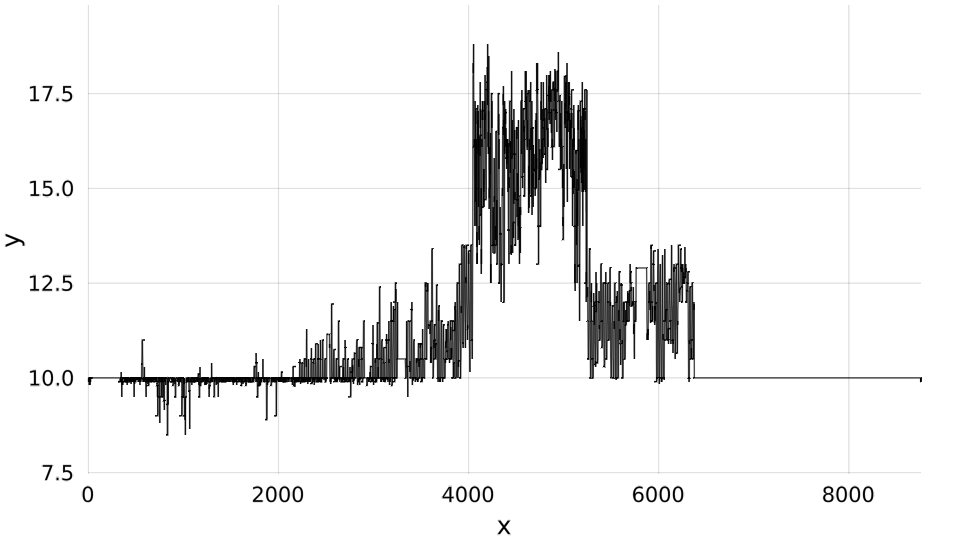

In [179]:
using Makie
using StatsMakie
using AbstractPlotting

mpipeline1 = Pipeline(Dict(
  :transformers => [csvfilter,valgator,valnner]
 )
)
fit!(mpipeline1)
res = transform!(mpipeline1)
res[:Value] = convert(Array{Float64},res[:Value])
lines(res[:Value],markersize=10)

### Monotonicer

In [11]:
regularfile = joinpath(dirname(pathof(TSML)),"../data/typedetection/regular.csv")
monofile = joinpath(dirname(pathof(TSML)),"../data/typedetection/monotonic.csv")
dailymonofile = joinpath(dirname(pathof(TSML)),"../data/typedetection/dailymonotonic.csv")
regularfilecsv = DataReader(Dict(:filename=>regularfile,:dateformat=>"dd/mm/yyyy HH:MM"))
monofilecsv = DataReader(Dict(:filename=>monofile,:dateformat=>"dd/mm/yyyy HH:MM"))
dailymonofilecsv = DataReader(Dict(:filename=>dailymonofile,:dateformat=>"dd/mm/yyyy HH:MM"))

valgator = DateValgator(Dict(:dateinterval=>Dates.Hour(1)))
valnner = DateValNNer(Dict(:dateinterval=>Dates.Hour(1)))
stfier = Statifier(Dict(:processmissing=>true))
mono = Monotonicer(Dict());

In [12]:
regpipeline = Pipeline(Dict(
  :transformers => [regularfilecsv,valgator,valnner,mono]
 )
)
fit!(regpipeline)
regulardf=transform!(regpipeline)
first(regulardf,10)

,Date,Value
,DateTime,Float64⍰
1,2014-01-01T01:00:00,4.5
2,2014-01-01T02:00:00,4.35
3,2014-01-01T03:00:00,4.05
4,2014-01-01T04:00:00,4.45
5,2014-01-01T05:00:00,4.2
6,2014-01-01T06:00:00,5.1
7,2014-01-01T07:00:00,5.15
8,2014-01-01T08:00:00,4.3
9,2014-01-01T09:00:00,4.45


┌ Info: Recompiling stale cache file /Users/ppalmes/.julia/compiled/v1.0/Makie/iZ1Bl.ji for Makie [ee78f7c6-11fb-53f2-987a-cfe4a2b5a57a]
└ @ Base loading.jl:1190
┌ Warning: Error requiring SpecialFunctions from Quadmath:
│ LoadError: ArgumentError: Package Quadmath does not have SpecialFunctions in its dependencies:
│ - If you have Quadmath checked out for development and have
│   added SpecialFunctions as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Quadmath
│ Stacktrace:
│  [1] require(::Module, ::Symbol) at ./loading.jl:836
│  [2] include at ./boot.jl:317 [inlined]
│  [3] include_relative(::Module, ::String) at ./loading.jl:1044
│  [4] include at ./sysimg.jl:29 [inlined]
│  [5] include(::String) at /Users/ppalmes/.julia/packages/Quadmath/7sXZj/src/Quadmath.jl:1
│  [6] top-level scope at /Users/ppalmes/.julia/packages/Quadmath/7sXZj/src/Quadmath.jl:111
│  [7] eval at ./boot.jl:31

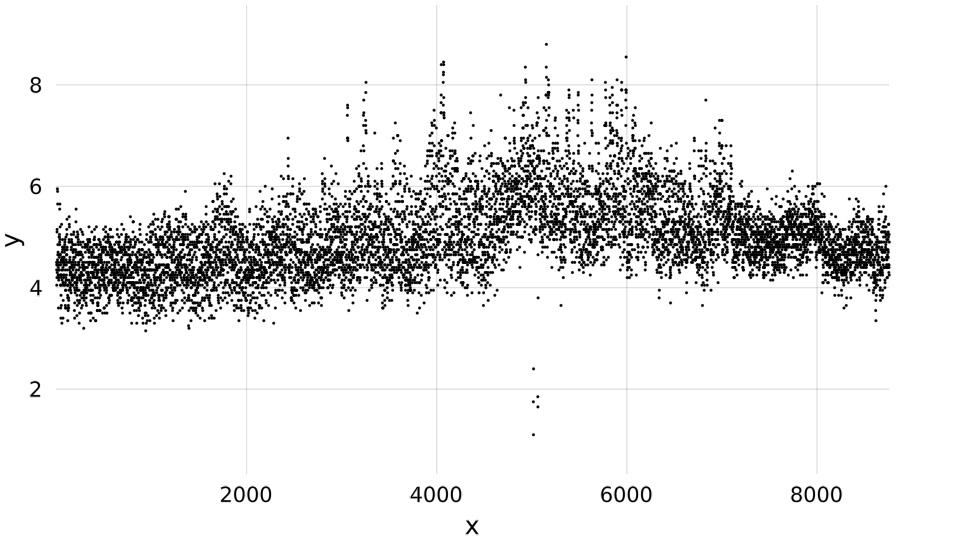

In [13]:
using Makie
using StatsMakie
using AbstractPlotting

regulardf[:Value] = convert(Array{Float64},regulardf[:Value])
scatter(regulardf[:Value],markersize=30)

In [187]:
monopipeline = Pipeline(Dict(
  :transformers => [monofilecsv,valgator,valnner,mono]
 )
)
fit!(monopipeline)
monodf=transform!(monopipeline)
first(monodf,10)

,Date,Value
,DateTime,Float64
1,2016-01-06T17:00:00,230.0
2,2016-01-06T18:00:00,230.0
3,2016-01-06T19:00:00,264.0
4,2016-01-06T20:00:00,258.0
5,2016-01-06T21:00:00,244.0
6,2016-01-06T22:00:00,254.0
7,2016-01-06T23:00:00,242.0
8,2016-01-07T00:00:00,240.0
9,2016-01-07T01:00:00,240.0


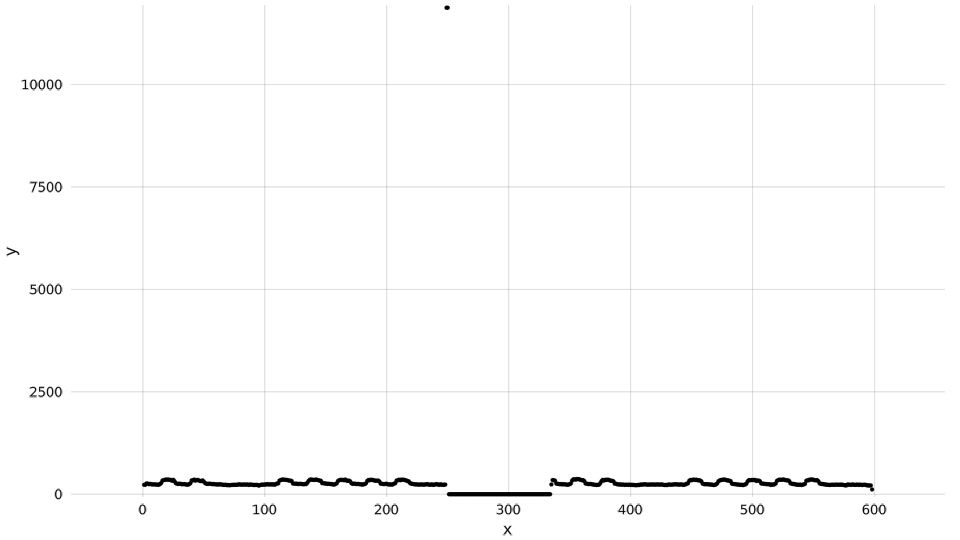

In [188]:
monodf[:Value] = convert(Array{Float64},monodf[:Value])
scatter(monodf[:Value],markersize=100)

In [191]:
dailymonopipeline = Pipeline(Dict(
  :transformers => [dailymonofilecsv,valgator,valnner,mono]
 )
)
fit!(dailymonopipeline)
dailymonodf=transform!(dailymonopipeline)
first(dailymonodf,10)

,Date,Value
,DateTime,Float64
1,2019-02-10T12:00:00,2.35
2,2019-02-10T13:00:00,2.35
3,2019-02-10T14:00:00,0.205
4,2019-02-10T15:00:00,0.205
5,2019-02-10T16:00:00,0.205
6,2019-02-10T17:00:00,0.18
7,2019-02-10T18:00:00,0.94
8,2019-02-10T19:00:00,0.24
9,2019-02-10T20:00:00,0.24


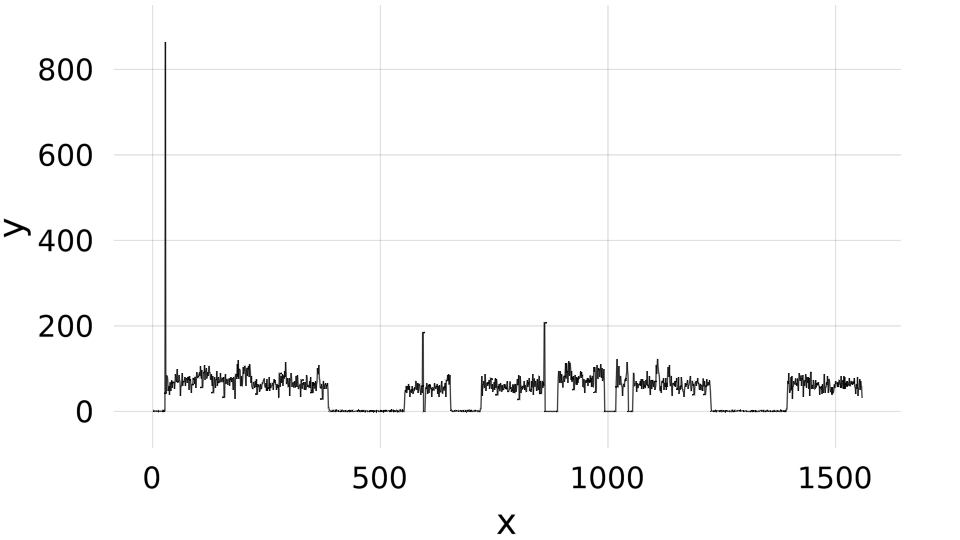

In [193]:
dailymonodf[:Value] = convert(Array{Float64},dailymonodf[:Value])
lines(dailymonodf[:Value],markersize=10)

In [14]:
wireframe(
     density(trim=true),
     Data(iris), Group(:Species), :SepalLength, :SepalWidth,
     transparency = true, linewidth = 0.1
 )

UndefVarError: UndefVarError: iris not defined

In [15]:
using RDatasets

┌ Info: Recompiling stale cache file /Users/ppalmes/.julia/compiled/v1.0/RDatasets/JyIbx.ji for RDatasets [ce6b1742-4840-55fa-b093-852dadbb1d8b]
└ @ Base loading.jl:1190
